In [1]:
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
import FILE_PATHS
from model import UNET
import joblib


In [2]:
# Hyperparameters
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
NUM_EPOCHS = 20
NUM_WORKERS = 4
IMAGE_HEIGHT = 112
IMAGE_WIDTH = 112
PIN_MEMORY = True
LOAD_MODEL = False

filename = "../EchoNet-Dynamic/models/mask_model.joblib"

In [3]:
MODEL = UNET(in_channels=3, out_channels=1).to(DEVICE)

# Load the model from joblib
model_state_dict = joblib.load(filename)


# Load the state_dict into the model
MODEL.load_state_dict(model_state_dict)

# checkpoint = torch.load(filename)
# MODEL.load_state_dict(checkpoint)
MODEL.eval()
print()

In [4]:
def read_video_and_predict(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get the frames per second (fps) of the video
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Calculate the time interval between frames
    frame_interval_ms = int(1000 / fps)

    # Initialize a variable to keep track of the current frame number
    frames_list = []
    predictions_list = []
    current_frame = 0

    # Loop through the video frames
    while True:
        # Set the video's position to the current frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)

        # Read the frame
        ret, frame = cap.read()

        # Check if the frame was successfully read
        if not ret:
            break

        frames_list.append(frame)
        """
        # Display the frame using matplotlib
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {current_frame}")
        plt.show()
        """

        # Increment the current frame number based on the frame interval
        current_frame += 1

    # Release the video capture object
    cap.release()

    return frames_list, predictions_list

In [19]:
videos_path = f"{FILE_PATHS.NEW_DATA}"
videos_filesnames = os.listdir(videos_path)
sample_vid_path = f"{videos_path}/{videos_filesnames[2]}"
#sample_vid_path = "../EchoNet-Dynamic/videos/0X1A0A263B22CCD966.avi"

In [20]:
frames_list, predictions_list = read_video_and_predict(sample_vid_path)

In [21]:
frame = frames_list[0]
frame = cv2.resize(frame, (112, 112))
frame = frame / 255.0
frame = np.array(frame)

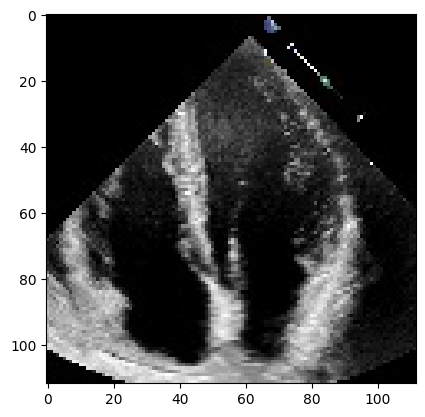

In [22]:
plt.imshow(frame)
plt.show()

In [23]:
frame = frames_list[0]
frame = cv2.resize(frame, (112, 112))
frame = np.array(frame)
frame = torch.from_numpy(frame)
frame = frame.to(DEVICE)
frame = frame.permute(2, 1, 0)
frame = frame.unsqueeze(0)
frame = frame.float()

In [24]:
pred = None
with torch.inference_mode():
    pred_tensor = torch.sigmoid(MODEL(frame))

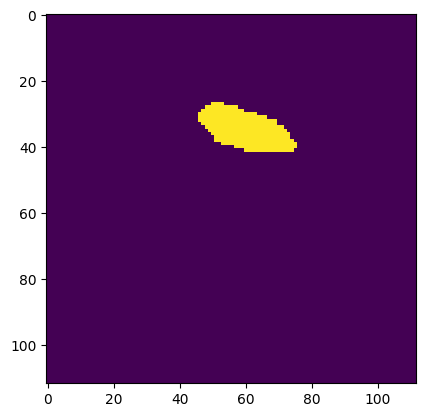

In [25]:
pred = pred_tensor.squeeze(0)
pred = pred.squeeze(0)
pred.shape
pred = pred.to("cpu").numpy()
pred = (pred >= 0.5)
plt.imshow(pred)
plt.show()